In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import scipy.linalg
import seaborn as sns

### General Functions

In [2]:
def kappa(l):
    integrand = lambda y: (15/16) * (1 - y**2)**2 * (y**l)
    result, _ = integrate.quad(integrand, -1, 1)
    return result

# Biweight kernel function
def biweight_kernel(u):
    return (15/16) * (1 - u**2)**2 * (np.abs(u) <= 1)

# Function to compute the T_j(K_i) for a given j and X_i
def T_j(x, j, h):
    if j == 0:
        return 1
    sum_result = 0
    for k in range((j // 2) + 1):
        sum_result += (math.comb(j, 2 * k) * x**(j - 2 * k) * h**(2 * k) * kappa(2 * k))
    return sum_result

# Function to compute the empirical moments
def t_j(x, j):
    return np.mean(x**j)

def v(l,T,target_moments):
    p = 1 / np.sum(l * T, axis=1)
    p /= np.sum(p)        
    V = np.dot(p, T) - target_moments
    return V

def line_search(J,q,point,T,target_moments):
    alpha = 1
    while (v(point,T,target_moments)**2).sum() - (v(point + alpha*q,T,target_moments)**2).sum() <= 1/2 * alpha * ((J@q)**2).sum():
        alpha *= 0.5
        if alpha <= 1e-10:
            break
    return alpha

### NO Constraints 

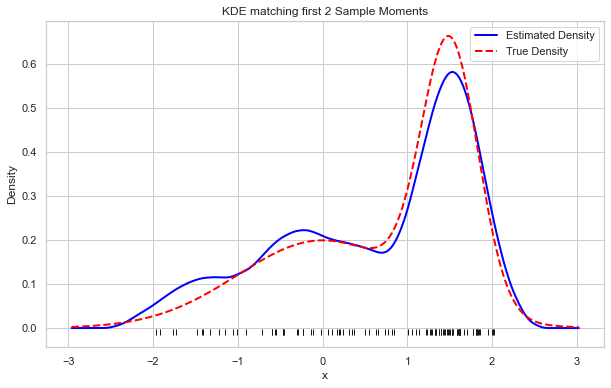

In [3]:
# Biweight kernel function
def biweight_kernel(u):
    return (15/16) * (1 - u**2)**2 * (np.abs(u) <= 1)

# Generate 100 data points from the asymmetric bimodal normal mixture 3/4N(0,1)+1/4N(3/2,1/9)
np.random.seed(42)  # For reproducibility
n = 100
x = np.concatenate([np.random.normal(0, 1, int(0.5 * n)), np.random.normal(1.5, 1/3, int(0.5 * n))])

# Bandwidth for kernel density estimation using biweight kernel
h = 0.65  # You can use a function to estimate bandwidth if needed

# Define a density estimation function using biweight kernel
def density_estimate(x_seq, data, h):
    n = len(data)
    density = np.zeros(len(x_seq))
    for i in range(len(x_seq)):
        u = (x_seq[i] - data) / h
        density[i] = np.sum(biweight_kernel(u)) / (n*h)
    return density

# Define the true density function for the asymmetric bimodal normal mixture
def true_density(x):
    return 0.5 * norm.pdf(x, 0, 1) + 0.5 * norm.pdf(x, 1.5, 1/3)

# Plot the kernel density estimate with the computed weights and the true density
x_seq = np.linspace(min(x) - 1, max(x) + 1, 1000)
density_values = density_estimate(x_seq, x, h)
true_density_values = true_density(x_seq)

# Set up the Seaborn plot with a grid
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=x_seq, y=density_values, label='Estimated Density', color='blue', linewidth=2)
sns.lineplot(x=x_seq, y=true_density_values, label='True Density', color='red', linestyle='--', linewidth=2)

# Add a rug plot for the data points using plt.plot
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

# Set the title and labels
plt.title('KDE matching first 2 Sample Moments')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()

# Save the plot to a file
plt.savefig('density_estimate_plot_no_constraint.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [4]:
first_moment_no = np.trapz(x_seq * density_values, x_seq)
second_moment_no = np.trapz(x_seq**2 * density_values, x_seq)
third_moment_no = np.trapz(x_seq**3 * density_values, x_seq)
fourth_moment_no = np.trapz(x_seq**4 * density_values, x_seq)

### first two moments 

Round 0, residual 1.1471539541614237
Round 1000, residual 0.02216403255503492
Round 2000, residual 0.00042848840553784363
Round 3000, residual 8.284154670019494e-06
Round 4000, residual 1.601622751884109e-07
Round 5000, residual 3.0965113238907468e-09
converge at 5870 with residual 9.999183703081084e-11
1.0


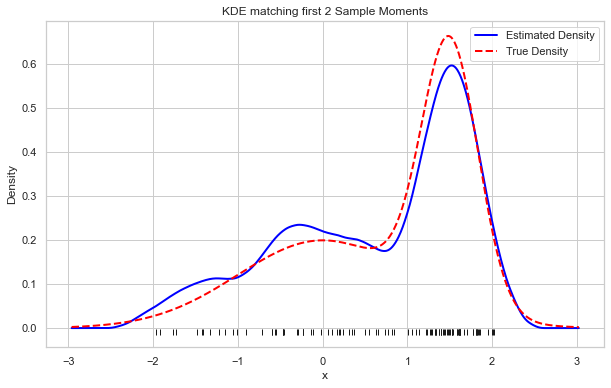

In [7]:
# Gauss-Newton optimization for lambda 
def gauss_newton(lambda_, x, h, r=2, tol=1e-10, max_iter=100000):
    n = len(x)
    T = np.array([[T_j(x_i, j, h) for j in range(r + 1)] for x_i in x])
    target_moments = np.array([1, t_j(x, 1), t_j(x, 2)])
    

    for _ in range(max_iter):
        p = 1 / np.sum(lambda_ * T, axis=1)
        p /= np.sum(p)
        
        V = np.dot(p, T) - target_moments
        J = -np.dot(T.T, (p[:, None]**2) * T)
        
        residual = (V**2).sum()
        mul = lambda x: J.T@(J@x)
        Jt_J = scipy.sparse.linalg.LinearOperator(
            shape=(J.shape[0] ,J.shape[0]), matvec=mul, rmatvec=mul, matmat=mul, rmatmat=mul)
        delta_lambda = scipy.sparse.linalg.cg(Jt_J, J.T@V, tol=min(1e-5, residual))[0]
        # alpha = line_search(J,delta_lambda,lambda_,T,target_moments)
        alpha = 0.00001
        lambda_ -= alpha*delta_lambda
        
        if residual < tol:
            print(f'converge at {_} with residual {residual}')
            break
        if _ % 1000 == 0:
            print(f'Round {_}, residual {residual}') 
    return lambda_

# Function to compute the weights
def compute_weights(x, h):
    n = len(x)
    
    # Initial guess for lambda, ensure it's a float array
    lambda_ = np.array([0.2, 0.3, 0.4])  # starting with lambda0 = 1 to avoid division by zero in initial calculation
    
    # Optimize lambda using Gauss-Newton method
    lambda_ = gauss_newton(lambda_, x, h)
    
    # Compute final weights
    T = np.array([[T_j(x_i, j, h) for j in range(3)] for x_i in x])
    final_weights = 1 / np.sum(lambda_ * T, axis=1)
    #final_weights = np.exp(np.sum(lambda_ * T, axis=1))
    # Ensure the weights sum to 1
    final_weights /= np.sum(final_weights)
    
    return final_weights, lambda_

# Define a density estimation function using biweight kernel
def density_estimate(x_seq, data, weights, h):
    n = len(data)
    density = np.zeros(len(x_seq))
    for i in range(len(x_seq)):
        u = (x_seq[i] - data) / h
        density[i] = np.sum(weights * biweight_kernel(u)) / (h)
    return density

# Generate 100 data points from the asymmetric bimodal normal mixture 3/4N(0,1)+1/4N(3/2,1/9)
np.random.seed(42)  # For reproducibility
n = 100
x = np.concatenate([np.random.normal(0, 1, int(0.5 * n)), np.random.normal(1.5, 1/3, int(0.5 * n))])

# Bandwidth for kernel density estimation using biweight kernel
h = 0.6  # You can use a function to estimate bandwidth if needed

# Compute the weights
weights, Lambda = compute_weights(x, h)

# Check sum of weights
print(np.sum(weights))  # This should be 1

# Define the true density function for the asymmetric bimodal normal mixture
def true_density(x):
    return 0.5 * norm.pdf(x, 0, 1) + 0.5 * norm.pdf(x, 1.5, 1/3)

# Plot the kernel density estimate with the computed weights and the true density
x_seq = np.linspace(min(x) - 1, max(x) + 1, 1000)
density_values = density_estimate(x_seq, x, weights, h)
true_density_values = true_density(x_seq)

# Set up the Seaborn plot with a grid
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=x_seq, y=density_values, label='Estimated Density', color='blue', linewidth=2)
sns.lineplot(x=x_seq, y=true_density_values, label='True Density', color='red', linestyle='--', linewidth=2)

# Add a rug plot for the data points using plt.plot
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

# Set the title and labels
plt.title('KDE matching first 2 Sample Moments')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()

# Save the plot to a file
plt.savefig('density_estimate_plot_2moments.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


<ipython-input-8-7978409eff4a>:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  (stemlines, stemmarkers, baseline) = plt.stem(x, weights, basefmt=" ", use_line_collection=True)


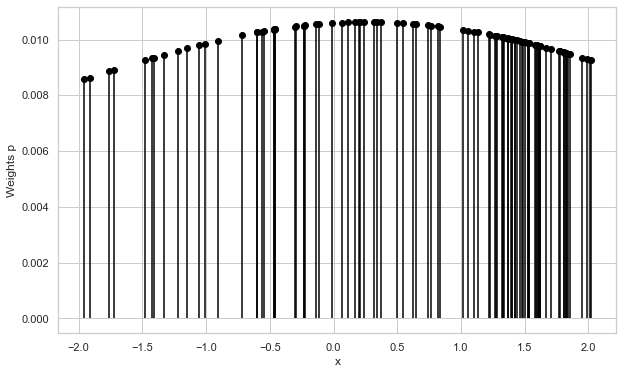

In [8]:
sns.set(style="whitegrid")

# Create the stem plot
plt.figure(figsize=(10, 6))
(stemlines, stemmarkers, baseline) = plt.stem(x, weights, basefmt=" ", use_line_collection=True)
plt.setp(stemlines, color='black')
plt.setp(stemmarkers, color='black')
plt.xlabel('x')
plt.ylabel('Weights p')

# Save the plot to a file
plt.savefig('stem_plot_2moments.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [9]:
first_moment_2 = np.trapz(x_seq * density_values, x_seq)
second_moment_2 = np.trapz(x_seq**2 * density_values, x_seq)
third_moment_2 = np.trapz(x_seq**3 * density_values, x_seq)
fourth_moment_2 = np.trapz(x_seq**4 * density_values, x_seq)

### first three moments

Round 0, residual 0.09010692275953779
Round 1000, residual 0.0007418866888153108
Round 2000, residual 6.106237237185612e-06
Round 3000, residual 5.025672791699798e-08
Round 4000, residual 4.136312233109778e-10
converge at 4296 with residual 9.990272496143488e-11
0.9999999999999998


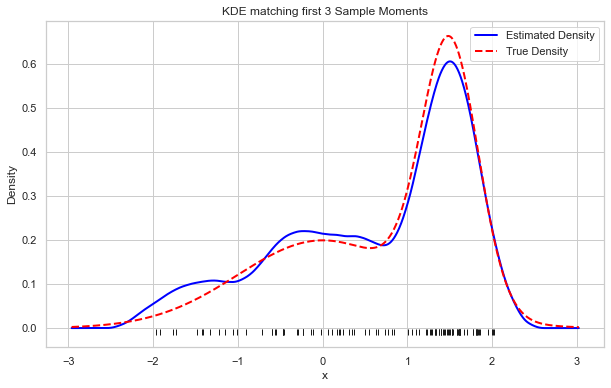

In [10]:
# Gauss-Newton optimization for lambda with regularization
def gauss_newton(lambda_, x, h, r=3, tol=1e-10, max_iter=100000):
    n = len(x)
    T = np.array([[T_j(x_i, j, h) for j in range(r + 1)] for x_i in x])
    target_moments = np.array([1, t_j(x, 1), t_j(x, 2),t_j(x, 3)])
    regularization = 1e-6  # Regularization term

    for _ in range(max_iter):
        p = 1 / np.sum(lambda_ * T, axis=1)
        p /= np.sum(p)
        
        V = np.dot(p, T) - target_moments
        J = -np.dot(T.T, (p[:, None]**2) * T)
        
        # Add regularization term to the diagonal
        # M += np.diag(regularization * np.ones(r + 1))
        # delta_lambda = scipy.linalg.pinv(M)@V
        # # delta_lambda,Code = cg(A,V,atol=1e-5)
        residual = (V**2).sum()
        mul = lambda x: J.T@(J@x)
        Jt_J = scipy.sparse.linalg.LinearOperator(
            shape=(J.shape[0] ,J.shape[0]), matvec=mul, rmatvec=mul, matmat=mul, rmatmat=mul)
        delta_lambda = scipy.sparse.linalg.cg(Jt_J, J.T@V, tol=min(1e-5, residual))[0]
        # alpha = line_search(J,delta_lambda,lambda_,T,target_moments)
        # print(alpha)
        alpha = 0.00001
        lambda_ -= alpha*delta_lambda
        
        if residual < tol:
            print(f'converge at {_} with residual {residual}')
            break
        if _ % 1000 == 0:
            print(f'Round {_}, residual {residual}') 
    return lambda_

# Function to compute the weights
def compute_weights(x, h):
    n = len(x)
    
    # Initial guess for lambda, ensure it's a float array
    lambda_ = np.array([0.37704664, -0.0025,  0.014,0.014 ])  # starting with lambda0 = 1 to avoid division by zero in initial calculation
    
    # Optimize lambda using Gauss-Newton method
    lambda_ = gauss_newton(lambda_, x, h)
    
    # Compute final weights
    T = np.array([[T_j(x_i, j, h) for j in range(4)] for x_i in x])
    final_weights = 1 / np.sum(lambda_ * T, axis=1)
    #final_weights = np.exp(np.sum(lambda_ * T, axis=1))
    # Ensure the weights sum to 1
    final_weights /= np.sum(final_weights)
    
    return final_weights, lambda_

# Define a density estimation function using biweight kernel
def density_estimate(x_seq, data, weights, h):
    n = len(data)
    density = np.zeros(len(x_seq))
    for i in range(len(x_seq)):
        u = (x_seq[i] - data) / h
        density[i] = np.sum(weights * biweight_kernel(u)) / (h)
    return density

# Generate 100 data points from the asymmetric bimodal normal mixture 3/4N(0,1)+1/4N(3/2,1/9)
np.random.seed(42)  # For reproducibility
n = 100
x = np.concatenate([np.random.normal(0, 1, int(0.5 * n)), np.random.normal(1.5, 1/3, int(0.5 * n))])

# Bandwidth for kernel density estimation using biweight kernel
h = 0.6  # You can use a function to estimate bandwidth if needed

# Compute the weights
weights, Lambda = compute_weights(x, h)

# Check sum of weights
print(np.sum(weights))  # This should be 1

# Define the true density function for the asymmetric bimodal normal mixture
def true_density(x):
    return 0.5 * norm.pdf(x, 0, 1) + 0.5 * norm.pdf(x, 1.5, 1/3)

# Plot the kernel density estimate with the computed weights and the true density
x_seq = np.linspace(min(x) - 1, max(x) + 1, 1000)
density_values = density_estimate(x_seq, x, weights, h)
true_density_values = true_density(x_seq)

# Set up the Seaborn plot with a grid
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=x_seq, y=density_values, label='Estimated Density', color='blue', linewidth=2)
sns.lineplot(x=x_seq, y=true_density_values, label='True Density', color='red', linestyle='--', linewidth=2)

# Add a rug plot for the data points using plt.plot
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

# Set the title and labels
plt.title('KDE matching first 3 Sample Moments')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()

# Save the plot to a file
plt.savefig('density_estimate_plot_3moments.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


<ipython-input-11-24da77e1d347>:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  (stemlines, stemmarkers, baseline) = plt.stem(x, weights, basefmt=" ", use_line_collection=True)


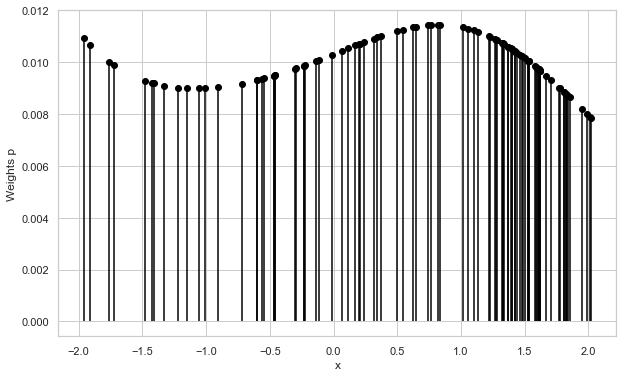

In [11]:
sns.set(style="whitegrid")

# Create the stem plot
plt.figure(figsize=(10, 6))
(stemlines, stemmarkers, baseline) = plt.stem(x, weights, basefmt=" ", use_line_collection=True)
plt.setp(stemlines, color='black')
plt.setp(stemmarkers, color='black')
plt.xlabel('x')
plt.ylabel('Weights p')

# Save the plot to a file
plt.savefig('stem_plot_3moments.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [12]:
first_moment_3 = np.trapz(x_seq * density_values, x_seq)
second_moment_3 = np.trapz(x_seq**2 * density_values, x_seq)
third_moment_3 = np.trapz(x_seq**3 * density_values, x_seq)
fourth_moment_3 = np.trapz(x_seq**4 * density_values, x_seq)

### first four moments 

Round 0, residual 0.2658152815895428
Round 1000, residual 0.0036849426849768063
Round 2000, residual 5.1045430005057335e-05
Round 3000, residual 7.07022669621572e-07
Round 4000, residual 9.79272956422464e-09
Round 5000, residual 1.3563552869321224e-10
converge at 5072 with residual 9.966881115055046e-11
0.9999999999999998


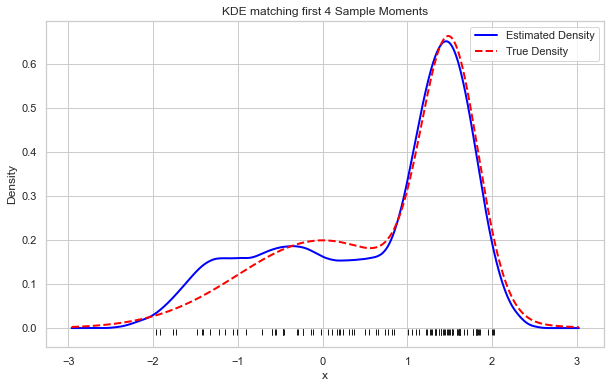

In [13]:
# Gauss-Newton optimization for lambda with regularization
def gauss_newton(lambda_, x, h, r=4, tol=1e-10, max_iter=100000):
    n = len(x)
    T = np.array([[T_j(x_i, j, h) for j in range(r + 1)] for x_i in x])
    target_moments = np.array([1, t_j(x, 1), t_j(x, 2),t_j(x, 3),t_j(x, 4)])
    regularization = 1e-6  # Regularization term

    for _ in range(max_iter):
        p = 1 / np.sum(lambda_ * T, axis=1)
        p /= np.sum(p)
        
        V = np.dot(p, T) - target_moments
        J = -np.dot(T.T, (p[:, None]**2) * T)
        
        # Add regularization term to the diagonal
        # M += np.diag(regularization * np.ones(r + 1))
        # delta_lambda = scipy.linalg.pinv(M)@V
        # # delta_lambda,Code = cg(A,V,atol=1e-5)
        residual = (V**2).sum()
        mul = lambda x: J.T@(J@x)
        Jt_J = scipy.sparse.linalg.LinearOperator(
            shape=(J.shape[0] ,J.shape[0]), matvec=mul, rmatvec=mul, matmat=mul, rmatmat=mul)
        delta_lambda = scipy.sparse.linalg.cg(Jt_J, J.T@V, tol=min(1e-5, residual))[0]
        # alpha = line_search(J,delta_lambda,lambda_,T,target_moments)
        # print(alpha)
        alpha = 0.00001
        lambda_ -= alpha*delta_lambda
        
        if residual < tol:
            print(f'converge at {_} with residual {residual}')
            break
        if _ % 1000 == 0:
            print(f'Round {_}, residual {residual}') 
    return lambda_

# Function to compute the weights
def compute_weights(x, h):
    n = len(x)
    
    # Initial guess for lambda, ensure it's a float array
    lambda_ = np.array([0.37704664, -0.0025,  0.014,0.014, 0.014 ])  # starting with lambda0 = 1 to avoid division by zero in initial calculation
    
    # Optimize lambda using Gauss-Newton method
    lambda_ = gauss_newton(lambda_, x, h)
    
    # Compute final weights
    T = np.array([[T_j(x_i, j, h) for j in range(5)] for x_i in x])
    final_weights = 1 / np.sum(lambda_ * T, axis=1)
    #final_weights = np.exp(np.sum(lambda_ * T, axis=1))
    # Ensure the weights sum to 1
    final_weights /= np.sum(final_weights)
    
    return final_weights, lambda_

# Define a density estimation function using biweight kernel
def density_estimate(x_seq, data, weights, h):
    n = len(data)
    density = np.zeros(len(x_seq))
    for i in range(len(x_seq)):
        u = (x_seq[i] - data) / h
        density[i] = np.sum(weights * biweight_kernel(u)) / (h)
    return density

# Generate 100 data points from the asymmetric bimodal normal mixture 3/4N(0,1)+1/4N(3/2,1/9)
np.random.seed(42)  # For reproducibility
n = 100
x = np.concatenate([np.random.normal(0, 1, int(0.5 * n)), np.random.normal(1.5, 1/3, int(0.5 * n))])

# Bandwidth for kernel density estimation using biweight kernel
h = 0.65  # You can use a function to estimate bandwidth if needed

# Compute the weights
weights, Lambda = compute_weights(x, h)
# Plot the kernel density estimate with the computed weights and the true density
x_seq = np.linspace(min(x) - 1, max(x) + 1, 1000)
density_values = density_estimate(x_seq, x, weights, h)


# Check sum of weights
print(np.sum(weights))  # This should be 1


# Define the true density function for the asymmetric bimodal normal mixture
def true_density(x):
    return 0.5 * norm.pdf(x, 0, 1) + 0.5 * norm.pdf(x, 1.5, 1/3)
true_density_values = true_density(x_seq)

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=x_seq, y=density_values, label='Estimated Density', color='blue', linewidth=2)
sns.lineplot(x=x_seq, y=true_density_values, label='True Density', color='red', linestyle='--', linewidth=2)

# Add a rug plot for the data points using plt.plot
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

# Set the title and labels
plt.title('KDE matching first 4 Sample Moments')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()

# Save the plot to a file
plt.savefig('density_estimate_plot_4moments.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

<ipython-input-14-78bf84fcba2e>:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  (stemlines, stemmarkers, baseline) = plt.stem(x, weights, basefmt=" ", use_line_collection=True)


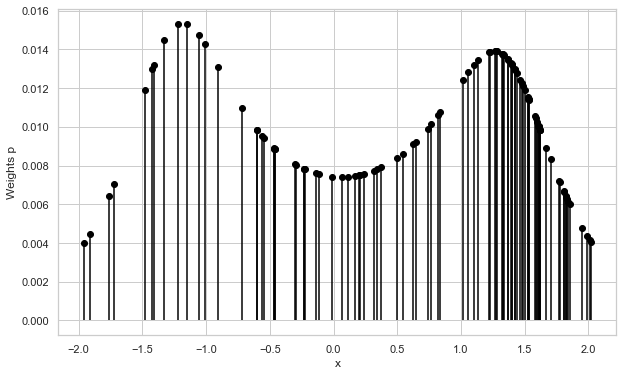

In [14]:
sns.set(style="whitegrid")

# Create the stem plot
plt.figure(figsize=(10, 6))
(stemlines, stemmarkers, baseline) = plt.stem(x, weights, basefmt=" ", use_line_collection=True)
plt.setp(stemlines, color='black')
plt.setp(stemmarkers, color='black')
plt.xlabel('x')
plt.ylabel('Weights p')

# Save the plot to a file
plt.savefig('stem_plot_4moments.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [15]:
first_moment_4 = np.trapz(x_seq * density_values, x_seq)
second_moment_4 = np.trapz(x_seq**2 * density_values, x_seq)
third_moment_4 = np.trapz(x_seq**3 * density_values, x_seq)
fourth_moment_4 = np.trapz(x_seq**4 * density_values, x_seq)

### Moments Calculation

#### Sample Moments

In [16]:
first_moment = np.mean(x**1)

# Second moment
second_moment = np.mean(x**2)

# Third moment
third_moment = np.mean(x**3)

# Fourth moment
fourth_moment = np.mean(x**4)

first_moment,second_moment,third_moment,fourth_moment

(0.6402265257832553, 1.6280983026990745, 1.6485458182090604, 4.126163197216001)

In [17]:
first_moment_no,second_moment_no,third_moment_no,fourth_moment_no

(0.640226532659547, 1.6884554507383847, 1.764472569891029, 4.724267690576788)

In [18]:
first_moment_2,second_moment_2,third_moment_2,fourth_moment_2

(0.6402204207225635, 1.6280903775190376, 1.730999423329134, 4.438247097290761)

In [19]:
first_moment_3,second_moment_3,third_moment_3,fourth_moment_3

(0.6402225067515057, 1.6280967465368124, 1.6485367800084076, 4.399681894124159)

In [20]:
first_moment_4,second_moment_4,third_moment_4,fourth_moment_4

(0.6402236489921863, 1.6280949432066394, 1.6485391156255804, 4.126157351133958)